# MNIST Example

## Training

In [3]:
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
from torchvision.models import resnet18
from trainer import GenericTrainer
from metrics import accuracy

# To open the tensorboard summary run this command in your cmd inside your conda environment : 
# tensorboard --logdir=xxxx --port=xxxx (Fill in the xxxx, port can be 8080 for example)

# Some parameters to be set for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
epochs = 10
max_grad_norm = 10

# Setup transformations for the inputs and labels
transform = v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32), v2.Normalize(mean=(33.3285,), std=(78.5655,))]) # MNIST training dataset mean and std
target_transform = lambda x:F.one_hot(torch.tensor(x), num_classes=10).float()

# Setup the dataset and dataloaders
training_dataset = MNIST(root=r"../data/raw", train=True, download=True, transform=transform, target_transform=target_transform)
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = MNIST(root=r"../data/raw", train=False, download=True, transform=transform, target_transform=target_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
# Setup the model and change its input channels from 3 (RGB) to 1 (Grayscale)
model = resnet18(num_classes=10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer=optimizer, factor=1., total_iters=epochs)

# Setup loss and metrics
loss = torch.nn.CrossEntropyLoss()
metrics = {"Accuracy" : accuracy}

# Setup the trainer and train
trainer = GenericTrainer(device=device, model=model, loss=loss, metrics=metrics, optimizer=optimizer, scheduler=scheduler, 
                        max_grad_norm=max_grad_norm, fp16_precision=True, log_every_n_steps=25, save_every_n_epochs=5, 
                        epochs=epochs, seed=42, verbose=True)
trainer.train(training_loader, val_loader)

## Visualizing the results

In [4]:
import torch
from torchvision.models import resnet18

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_to_model = r"runs\Nov21_09-21-56_Work_PC_Jad\checkpoint_00010.pt" # Example path, replace with your own
checkpoint = torch.load(path_to_model) # Load the checkpoint

# Setup the model and change its input channels from 3 (RGB) to 1 (Grayscale)
model = resnet18(num_classes=10)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # There is unfortunately no external way to change the input channel size
model.load_state_dict(checkpoint["state_dict"]) # Load the model weights into the newly initialized model
model = model.to(device)
model = model.eval()

C:\Users\haida\AppData\Local\Temp\ipykernel_23984\3188810459.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_model) # Load the checkpoint

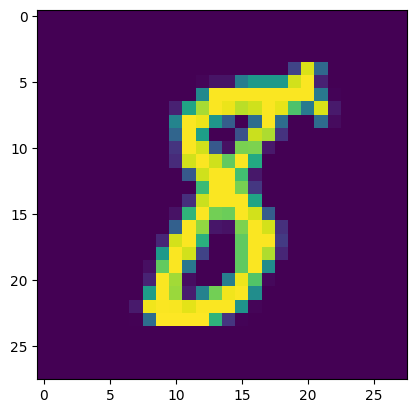

Label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), argmax: 8
Prediction : [7.51e-14 6.35e-13 1.40e-13 7.25e-12 2.24e-12 1.09e-09 2.14e-11 1.87e-13
 1.00e+00 6.76e-13], argmax: 8


In [6]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=2)

idx = 125
image, label = training_dataset[idx]
with torch.no_grad():
    prediction = torch.softmax(model(image.to(device).unsqueeze(0)), dim=-1).cpu().numpy()

plt.imshow(image.numpy().squeeze())
plt.show()
print(f"Label : {label}, argmax: {label.argmax(dim=-1)}\nPrediction : {prediction.flatten()}, argmax: {prediction.argmax(axis=-1)[0]}")